# <center>Appendix</center>

## Importing Libraries

In [1]:
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import colors
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer

if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

## Importing Dataset

In [2]:
#Loading the dataset
data = pd.read_csv("data/marketing_campaign.csv", sep="\t")
print("No. of datapoints:", len(data))
print("No. of columns:", len(data.columns))
data.head()

No. of datapoints: 2240
No. of columns: 29


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


## Data Preprocessing

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

**Observations:**
1. There are null values in the income column of our data frame, and the "Dt_Customer" column is not formatted as a date.
2. Additionally, some of the columns in our data frame are categorical, and will need to be encoded into numeric form before they can be used in further analysis.

In [4]:
# Removing null values
data = data.dropna()
print(f"After removing the null values data contains {len(data)}")

After removing the null values data contains 2216


In the next step, I will create a new feature **"Dt_Customer"** that indicates the number of days a customer has been registered in the firm's database. To keep things simple, I will make this value relative to the most recent customer in the record.

In [5]:
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"])

dates = [i.date() for i in data["Dt_Customer"]]

#Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in the records:", max(dates))
print("The oldest customer's enrolment date in the records:", min(dates))


The newest customer's enrolment date in the records: 2014-12-06
The oldest customer's enrolment date in the records: 2012-01-08


 I will create a new feature called **"Customer_For"** that indicates the number of days a customer has been shopping in the store, relative to the most recent date in the record

In [6]:
#Created a feature "Customer_For"
dates_max = max(dates)  #taking it to be the newest customer

days = [dates_max - i for i in dates]

data["Customer_For"] = days
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="coerce")

In [7]:
print("Total categories in the feature Marital_Status:\n", data["Marital_Status"].value_counts(), "\n")
print("Total categories in the feature Education:\n", data["Education"].value_counts())

Total categories in the feature Marital_Status:
 Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64 

Total categories in the feature Education:
 Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64


To extract the age of a customer, I will create a new feature called **"Age"** using the **"Year_Birth"** column. This new feature will indicate the birth year of the customer, allowing me to easily calculate their age.

I will also create a feature called **"Spent"** that indicates the total amount of money that a customer has spent in various categories over the past two years.

In addition, I will create a new feature called "Living_With" that uses the **"Marital_Status"** column to determine whether couples are living together or not.

Another feature I will create is **"Children"**, which indicates the total number of children and teenagers in a household. This will allow me to get a better understanding of the size and composition of each household.

To further clarify the makeup of each household, I will also create a new feature called **"Family_Size"** that indicates the total number of people living in a household.

Additionally, I will create a feature called **"Is_Parent"** that indicates whether a customer is a parent or not. This will allow me to better understand the family dynamics of each household.

Finally, I will create three categories in the **"Education"** column by simplifying its value counts. This will make it easier to analyze and compare the education levels of different customers.

After creating these new features, I will drop any redundant columns that are no longer needed.

In [8]:
#Feature Engineering
#Age of customer today
data["Age"] = 2021 - data["Year_Birth"]

#Total spendings on various items
data["Spent"] = data["MntWines"] + data["MntFruits"] + data["MntMeatProducts"] + data["MntFishProducts"] + data[
    "MntSweetProducts"] + data["MntGoldProds"]

#Deriving living situation by marital status"Alone"
data["Living_With"] = data["Marital_Status"].replace(
    {"Married": "Partner", "Together": "Partner", "Absurd": "Alone", "Widow": "Alone", "YOLO": "Alone",
     "Divorced": "Alone", "Single": "Alone", })

#Feature indicating total children living in the household
data["Children"] = data["Kidhome"] + data["Teenhome"]

#Feature for total members in the household
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner": 2}) + data["Children"]

#Feature pertaining parenthood
data["Is_Parent"] = np.where(data.Children > 0, 1, 0)

#Segmenting education levels in three groups
data["Education"] = data["Education"].replace(
    {"Basic": "Undergraduate", "2n Cycle": "Undergraduate", "Graduation": "Graduate", "Master": "Postgraduate",
     "PhD": "Postgraduate"})

#For clarity
data = data.rename(
    columns={"MntWines": "Wines", "MntFruits": "Fruits", "MntMeatProducts": "Meat", "MntFishProducts": "Fish",
             "MntSweetProducts": "Sweets", "MntGoldProds": "Gold"})

#Dropping some of the redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

In [9]:
data.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.064079,0.013538,0.009477,0.150271,4.423735e+16,52.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.244950,0.115588,0.096907,0.357417,2.008532e+16,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,25.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,2.937600e+16,44.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,4.432320e+16,51.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,5.927040e+16,62.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,9.184320e+16,128.000000,2525.000000,3.000000,5.000000,1.000000


**Observations:**
The statistics above show some inconsistencies in the mean and maximum values for income and age. It is worth noting that the maximum age is 128 years, but this value is likely not accurate because it is based on the current year (2021) and the data is from an older time period. This means that the age values may not be accurate and should be interpreted with caution.

In [10]:
# Initializing Color pallets

sns.set(rc={"axes.facecolor": "#edf9ff", "figure.facecolor": "#edf9ff"})
pallet = ["#2f2f68", "#6f729e", "#b1b2d6", "#c9c0b9", "#788a9f", "#60abf3"]
cmap = colors.ListedColormap(["#2f2f68", "#6f729e", "#D6B2B1", "#b1b2d6", "#788a9f", "#60abf3"])
pal = ["#2f2f68", "#c9c0b9", "#788a9f", "#60acf3"]

Relative Plot Of Some Selected Features: A Data Subset


<Figure size 800x550 with 0 Axes>

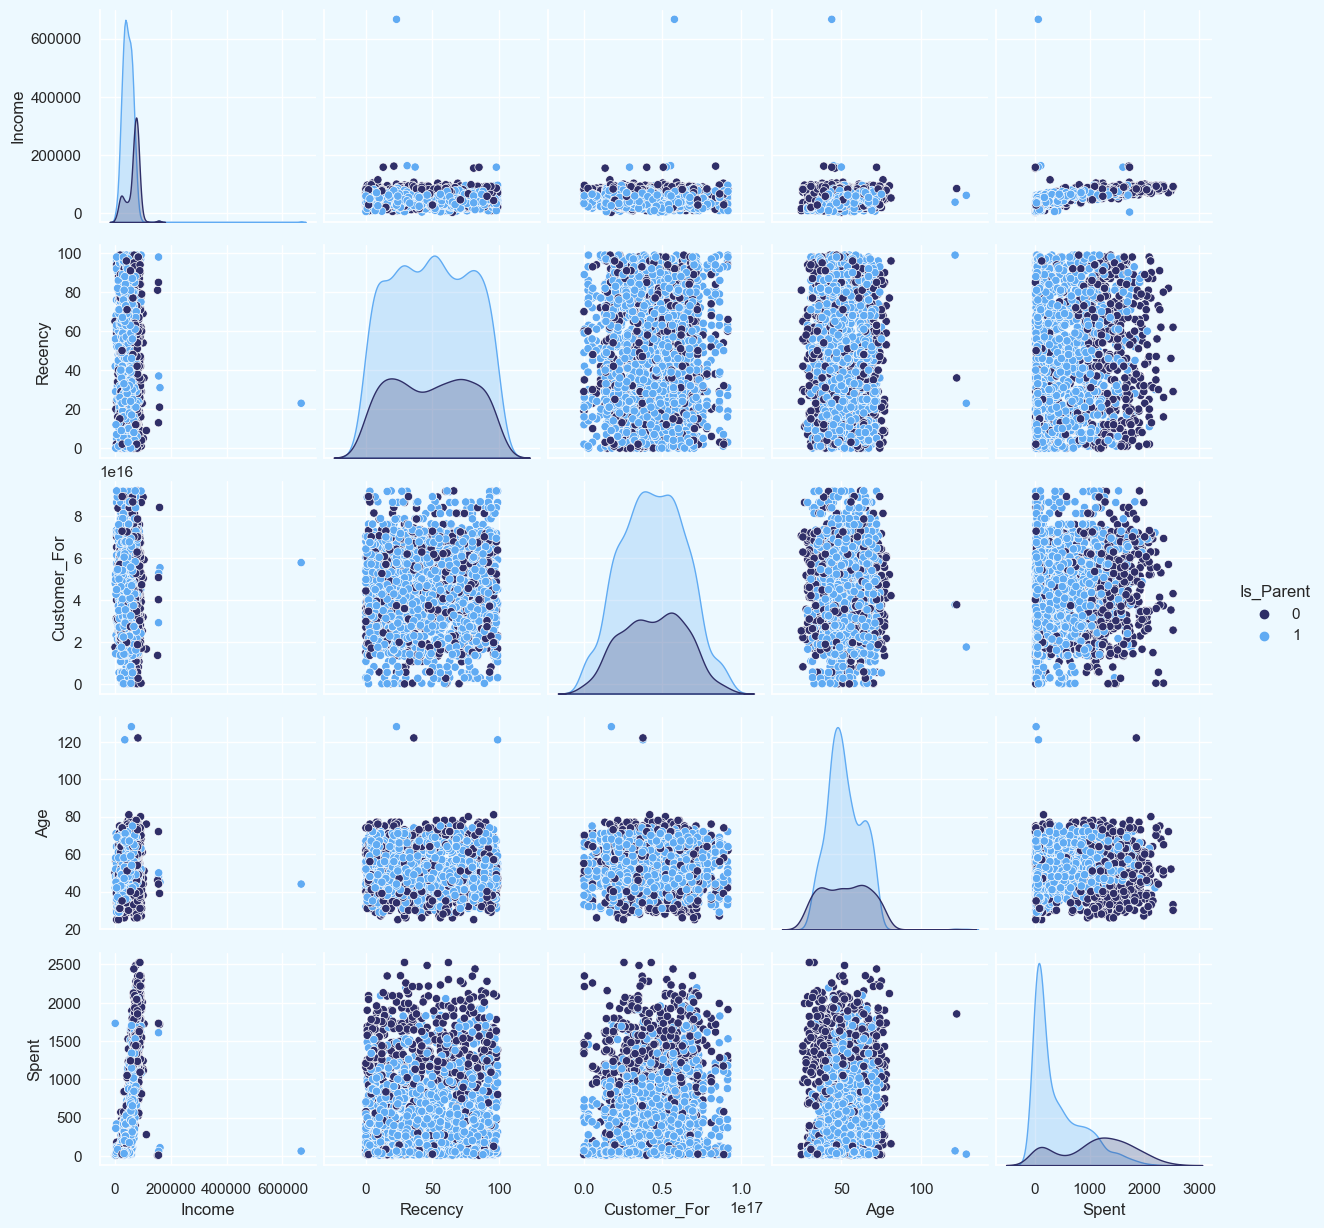

In [11]:
# Plotting following features
To_Plot = ["Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]

print("Relative Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(data[To_Plot], hue="Is_Parent", palette=(["#2f2f68", "#60abf3"]))
plt.show()

**Observations:**
From the plots above, it is clear that there are some outliers in the income and age features. These outliers may have a negative impact on the accuracy of our analysis, so I will remove them from the data. This will help to ensure that our results are more accurate and reliable.

In [12]:
#Dropping the outliers by setting a cap on Age and income.
data = data[(data["Age"] < 90)]
data = data[(data["Income"] < 600000)]
print(f"The total data-points after removing the outliers are: {len(data)}")

The total data-points after removing the outliers are: 2212


<AxesSubplot: >

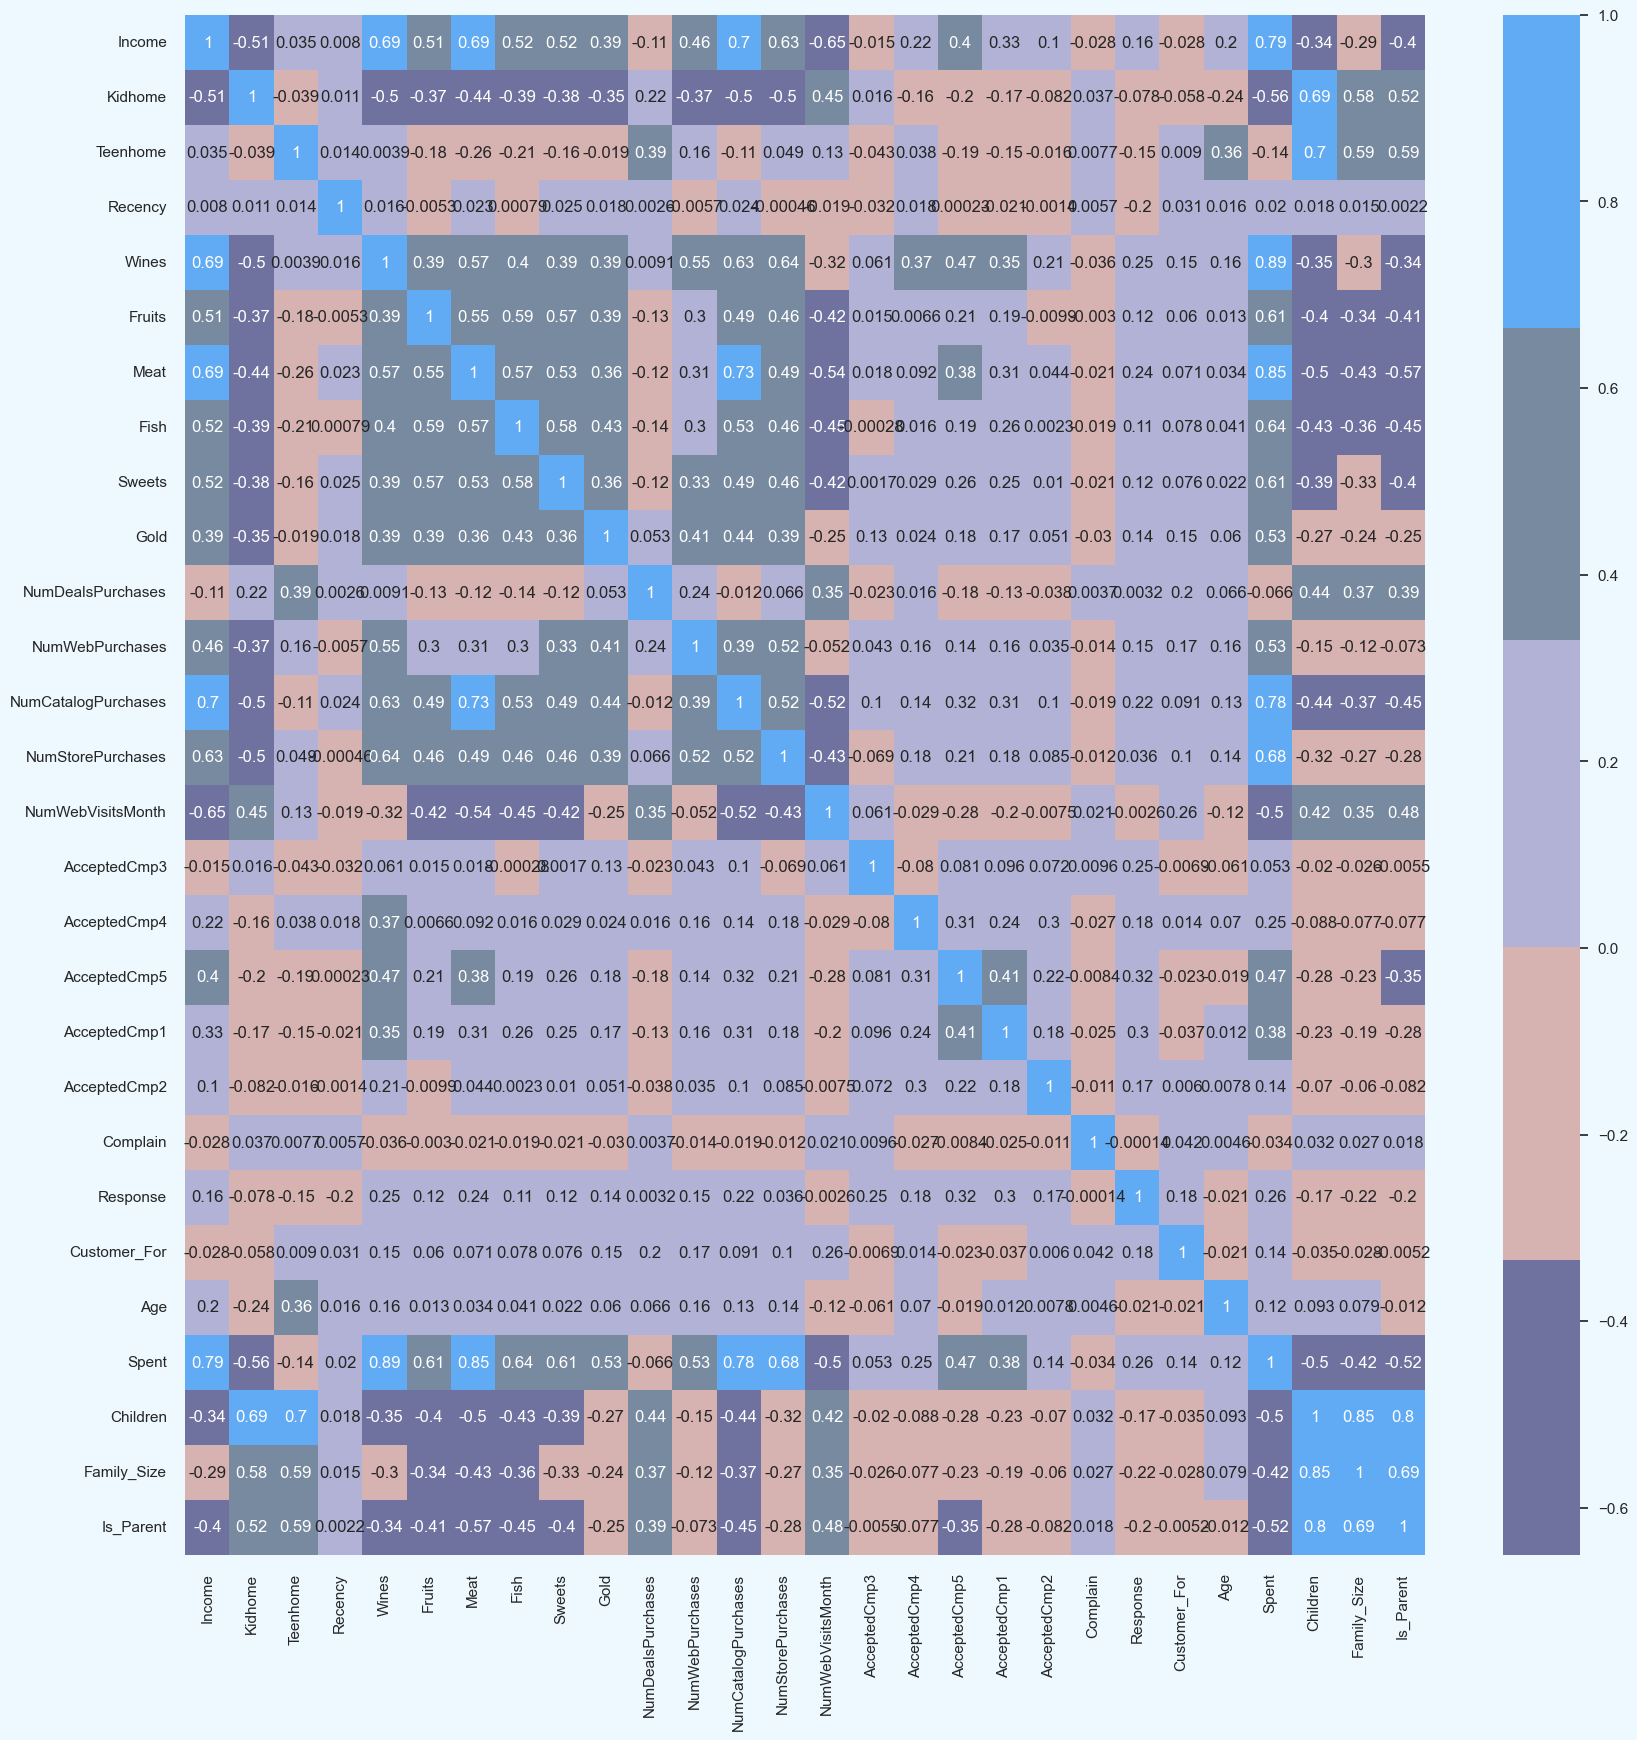

In [13]:
#correlation matrix
cor_mat = data.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(cor_mat, annot=True, cmap=cmap, center=0)

**Next steps:**

1. Use label encoding to convert the categorical features into numeric form.
2. Scale the features using the standard scaler to ensure that they are on the same scale.
3. Create a subset dataframe for dimensionality reduction to reduce the number of features and improve the efficiency of our analysis.

In [14]:
# Get list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Living_With']


In [15]:
# Using Label Encoding to convert categorical data to numerical.
LE = LabelEncoder()
for i in object_cols:
    data[i] = data[[i]].apply(LE.fit_transform)

print("All features are now numerical")

All features are now numerical


In [16]:
# Creating a copy of data
data_copy = data.copy()

# Creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response']
data_copy = data_copy.drop(cols_del, axis=1)

# Scaling
scaler = StandardScaler()
scaler.fit(data_copy)
scaled_ds = pd.DataFrame(scaler.transform(data_copy), columns=data_copy.columns)
print("All features are now scaled using standard scaler")

All features are now scaled using standard scaler


## Dimensionality Reduction

 In this problem, there are many factors or attributes that will be used to make the final classification. The more features there are, the harder it is to work with the data. Many of these features are correlated and redundant, so it is important to reduce the number of features in the data.

To accomplish this, I will perform dimensionality reduction on the selected features. Dimensionality reduction is the process of reducing the number of random variables by obtaining a set of principal variables. This will help to simplify the data and improve the efficiency of our analysis.

After reducing the dimensionality of the data, I will put the features through a classifier to make the final classification. This will help to identify any patterns or trends in the data and make more accurate predictions.

For this project, I will use principal component analysis (PCA) to perform dimensionality reduction on the selected features. PCA is a statistical technique that is used to reduce the number of dimensions in a dataset while preserving as much information as possible.

After applying PCA, I will reduce the dimensions to 3, which will make it easier to visualize the results and see how the different features are distributed. I will then plot the reduced dataframe to see the results of the dimensionality reduction and identify any patterns or trends in the data.

In [17]:
#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(scaled_ds)
pca_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1", "col2", "col3"]))
pca_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2212.0,-3.854662e-17,2.878377,-5.969394,-2.538494,-0.780421,2.383290,7.444305
col2,2212.0,-2.569775e-17,1.706839,-4.312196,-1.328316,-0.158123,1.242289,6.142721
col3,2212.0,5.701688e-17,1.221956,-3.530416,-0.829067,-0.022692,0.799895,6.611222


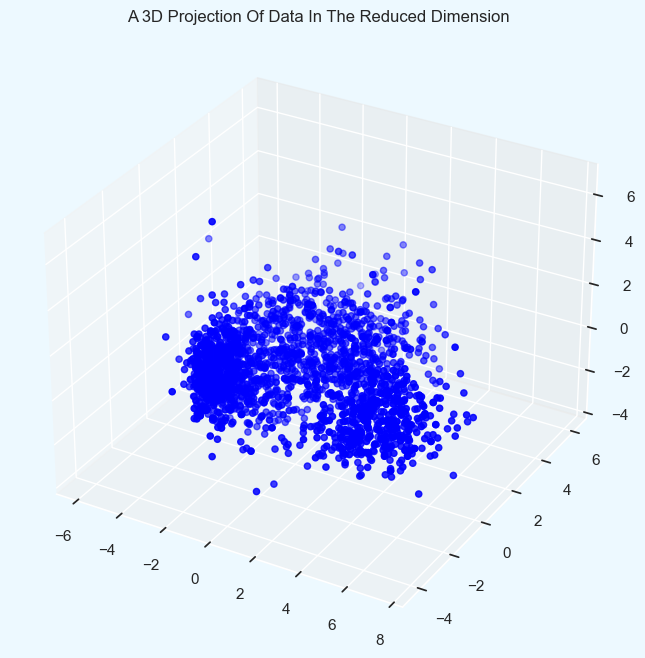

In [18]:
# A 3D Projection Of Data In The Reduced Dimension
x = pca_ds["col1"]
y = pca_ds["col2"]
z = pca_ds["col3"]

# Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x, y, z, c="blue", marker="o")
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

## Clustering

In order to perform clustering, I will use Agglomerative clustering on the reduced dataset, which has three dimensions. Agglomerative clustering is a hierarchical clustering method that involves merging individual examples into clusters until the desired number of clusters is reached.

The steps involved in the clustering process are:

1. Using the Elbow Method to determine the optimal number of clusters to form.
2. Performing clustering using Agglomerative Clustering.
3. Examining the resulting clusters using a scatter plot.

Elbow Method to determine the number of clusters to be formed:


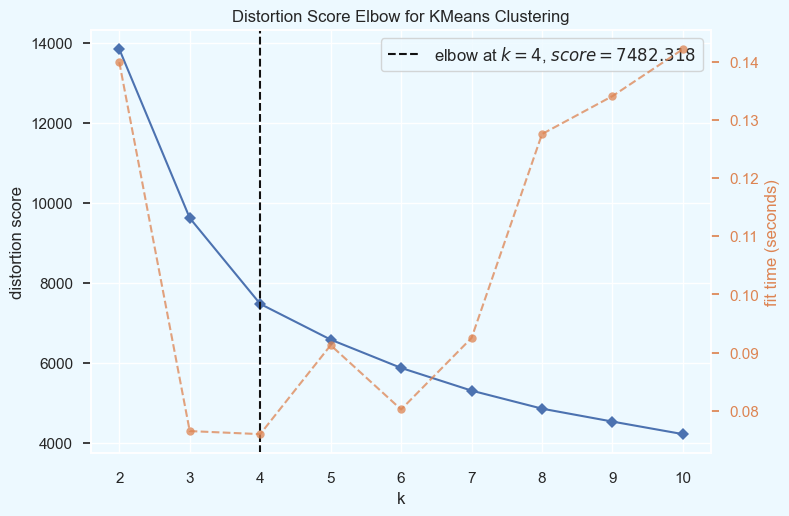

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [19]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(pca_ds)
Elbow_M.show()

**Observations:**
The previous cell suggests that four clusters will be optimal for this dataset. Next, we will fit the Agglomerative Clustering Model to the data to obtain the final clusters.

In [20]:
#Initiating the Agglomerative Clustering model
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(pca_ds)
pca_ds["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
data["Clusters"] = yhat_AC

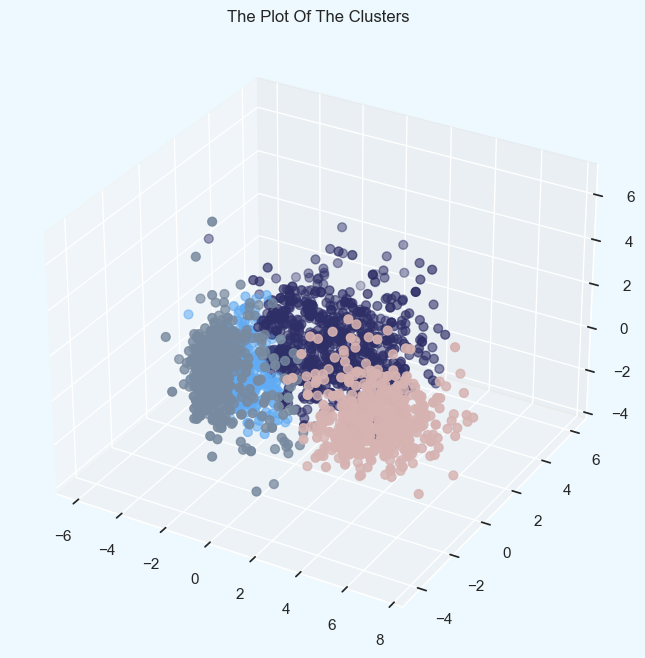

In [21]:
#Plotting the clusters
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=pca_ds["Clusters"], marker='o', cmap=cmap)
ax.set_title("The Plot Of The Clusters")
plt.show()

## Evaluating Model

Since this is an unsupervised clustering task, there is no labeled feature to use for evaluating or scoring the model. The purpose of this section is to study the patterns within the clusters that were formed and determine the nature of these patterns. To do this, we will use exploratory data analysis to examine the data in relation to the clusters and draw conclusions based on the resulting patterns.

Firstly, let us have a look at the group distribution of clustering

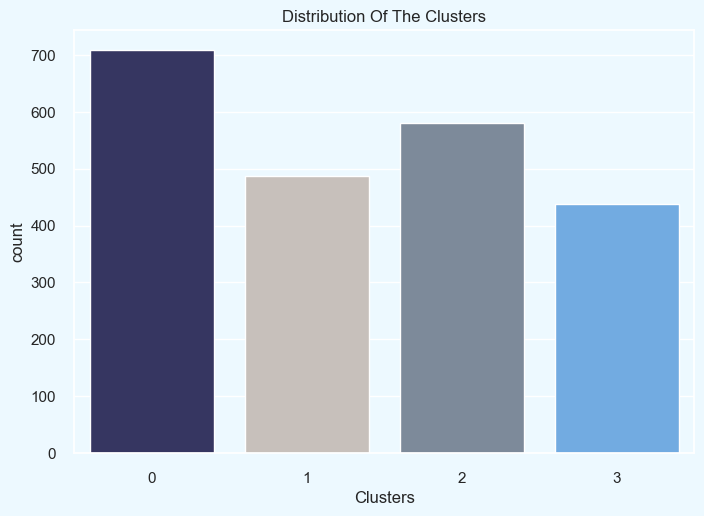

In [22]:
fig = sns.countplot(x=data["Clusters"], palette=pal)
fig.set_title("Distribution Of The Clusters")
plt.show()

**Observations:**
The clusters appear to be uniformly distributed.

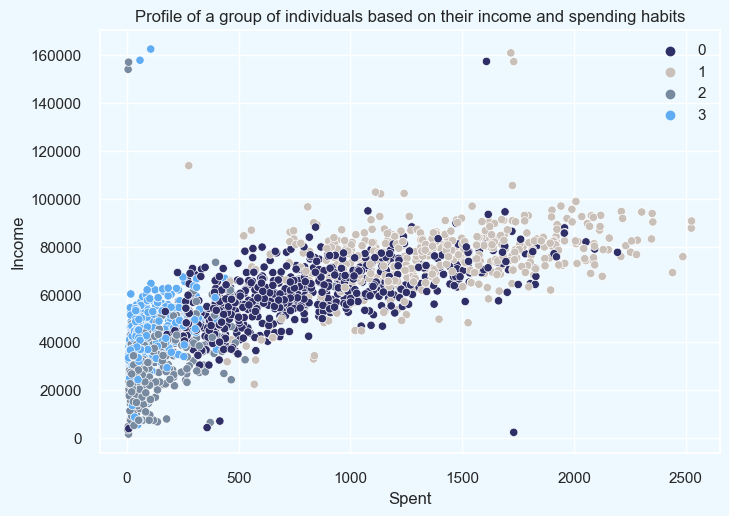

In [23]:
fig = sns.scatterplot(data=data, x=data["Spent"], y=data["Income"], hue=data["Clusters"], palette=pal)
fig.set_title("Profile of a group of individuals based on their income and spending habits")
plt.legend()
plt.show()

Income vs  spending plot shows the clusters pattern:
•	Group 0: those with average income and high spending
•	Group 1: those with high income and high spending
•	Group 2: those with low income and low spending
•	Group 3: those with low income and high spending


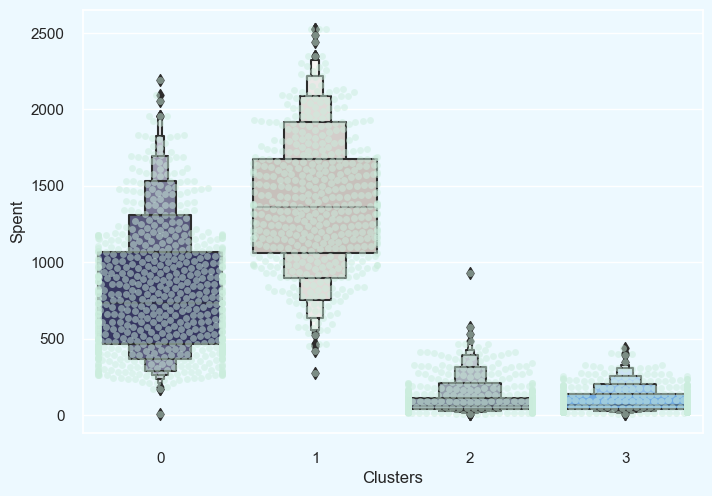

In [24]:
plt.figure()
fig = sns.swarmplot(x=data["Clusters"], y=data["Spent"], color="#CBEDDD", alpha=0.5)
fig = sns.boxenplot(x=data["Clusters"], y=data["Spent"], palette=pal)
plt.show()

**Observations:**
Based on the plot above, it appears that cluster 1 is the largest group of customers, followed closely by cluster 0. We can explore the spending habits of each cluster to inform targeted marketing strategies.

**Exploring past campaigns**

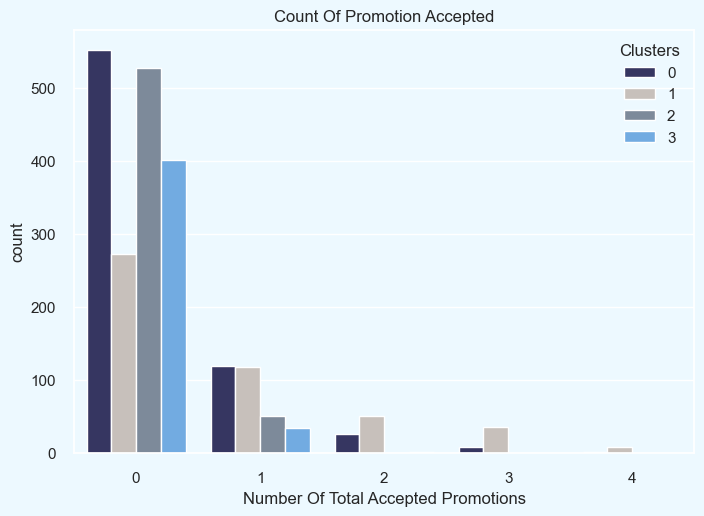

In [25]:
#Creating a feature to get a sum of accepted promotions
data["Total_Promos"] = data["AcceptedCmp1"] + data["AcceptedCmp2"] + data["AcceptedCmp3"] + data["AcceptedCmp4"] + data[
    "AcceptedCmp5"]
#Plotting count of total campaign accepted.
plt.figure()
fig = sns.countplot(x=data["Total_Promos"], hue=data["Clusters"], palette=pal)
fig.set_title("Count Of Promotion Accepted")
fig.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

**Observations:**
The response to the marketing campaigns has been relatively weak, with only a small number of participants overall. Furthermore, no one has participated in all five of the campaigns. This suggests that more targeted and well-planned campaigns may be necessary in order to boost sales.

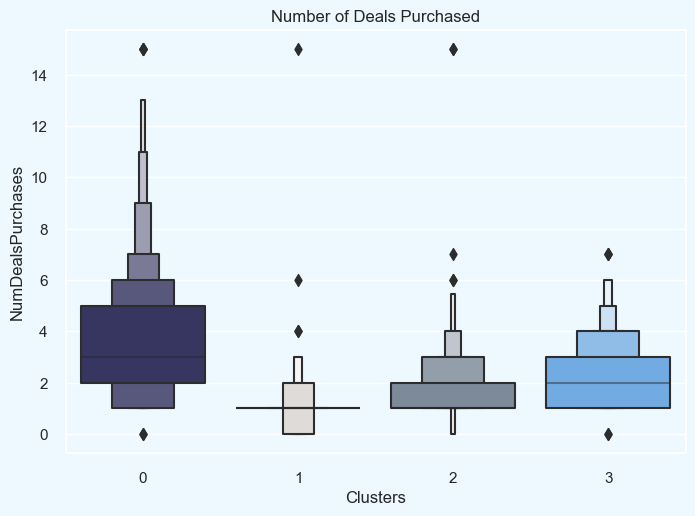

In [26]:
#Plotting the number of deals purchased
plt.figure()
pl = sns.boxenplot(y=data["NumDealsPurchases"], x=data["Clusters"], palette=pal)
pl.set_title("Number of Deals Purchased")
plt.show()

**Observations:**
In contrast to the campaigns, the deals offered were more successful. They had the best results with cluster 0 and cluster 3. However, our most valuable customers in cluster 1 did not seem to be very interested in the deals. There does not appear to be anything that particularly attracts customers in cluster 2.

<Figure size 800x550 with 0 Axes>

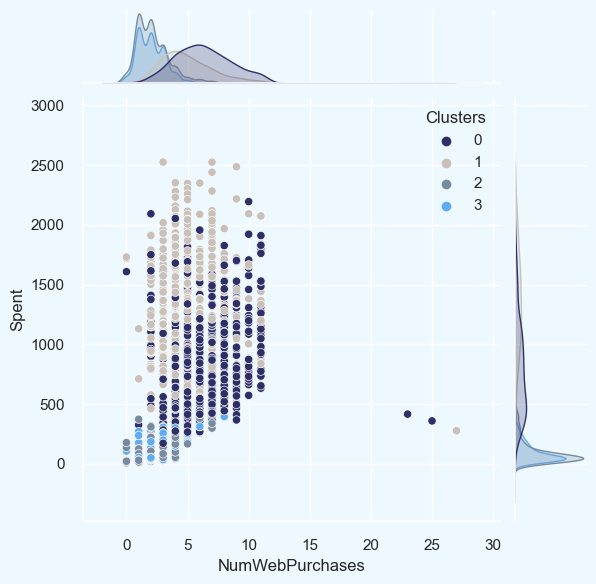

<Figure size 800x550 with 0 Axes>

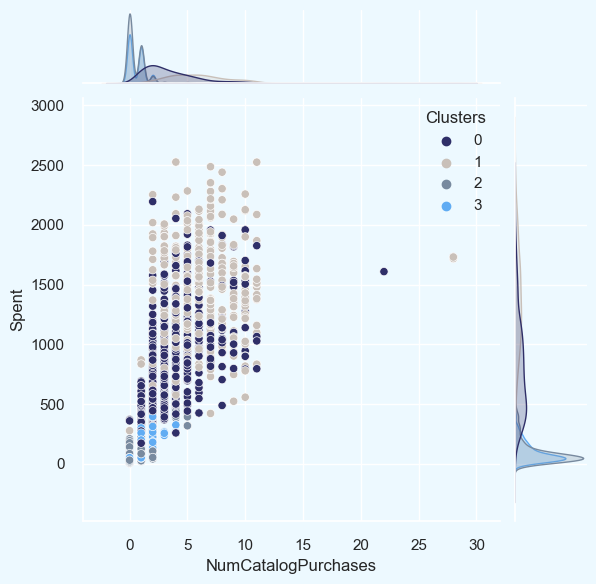

<Figure size 800x550 with 0 Axes>

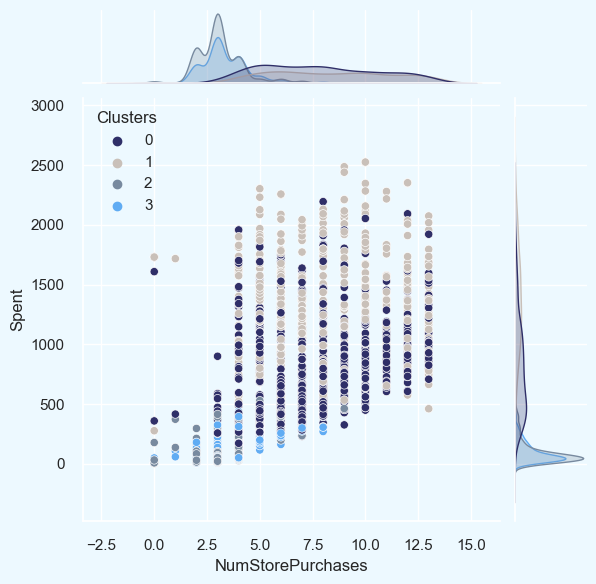

<Figure size 800x550 with 0 Axes>

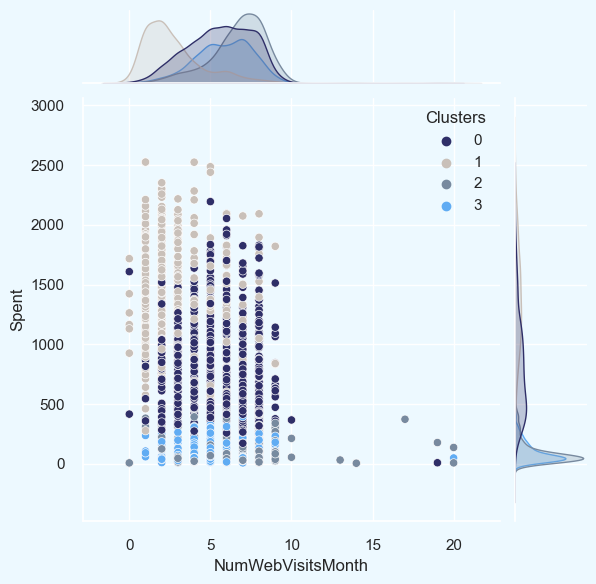

In [27]:
# for more details on the purchasing style
purchases = ["NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases", "NumWebVisitsMonth"]

for i in purchases:
    plt.figure()
    sns.jointplot(x=data[i], y=data["Spent"], hue=data["Clusters"], palette=pal)
    plt.show()

## Profiling

Now that we have formed the clusters and examined their purchasing habits, let us take a closer look at the individuals in each cluster. To do this, we will create profiles of the clusters and use this information to determine which customers are our most valuable and which ones require more attention from the retail store's marketing team.

To make this determination, I will plot some of the features that are indicative of a customer's personal traits in relation to the cluster they are in. Based on the results of this analysis, I will draw conclusions about the characteristics of each cluster.

<Figure size 800x550 with 0 Axes>

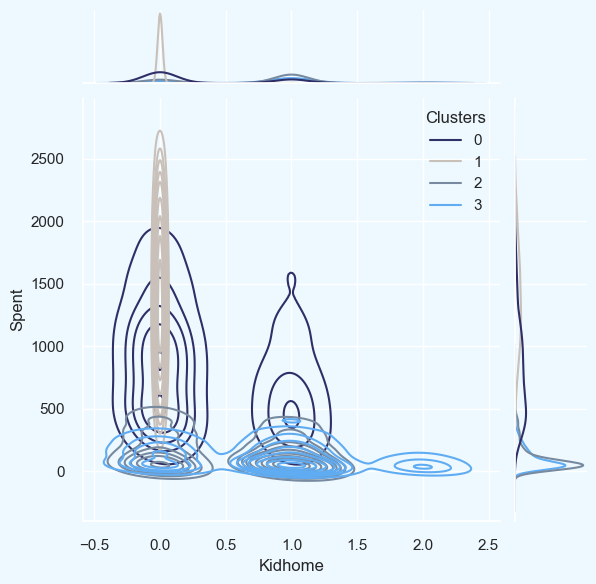

<Figure size 800x550 with 0 Axes>

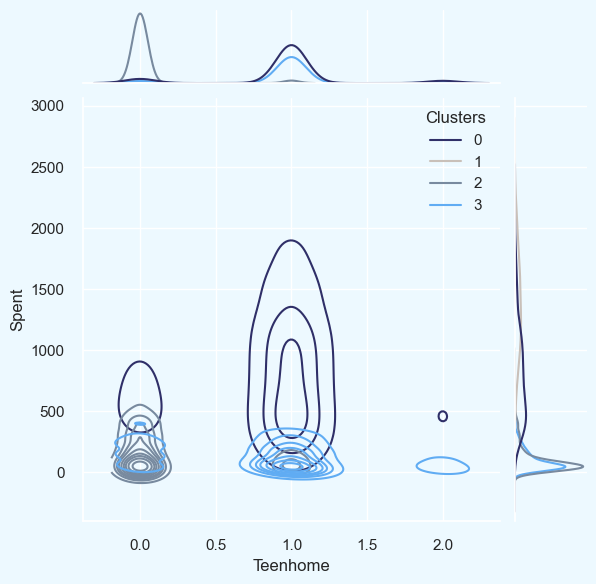

<Figure size 800x550 with 0 Axes>

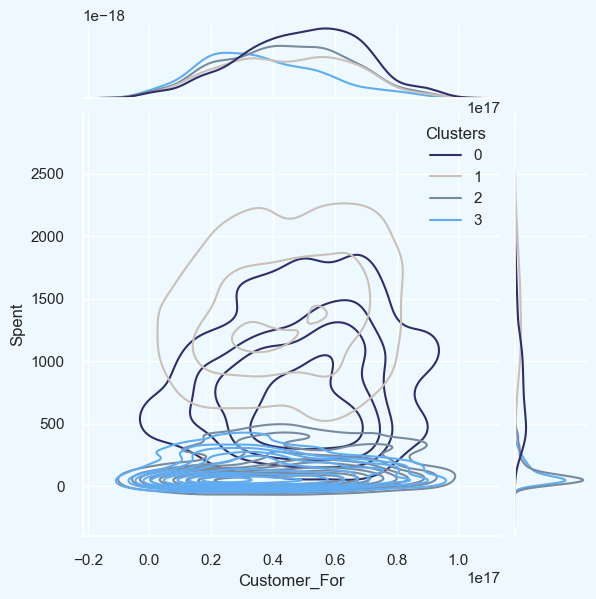

<Figure size 800x550 with 0 Axes>

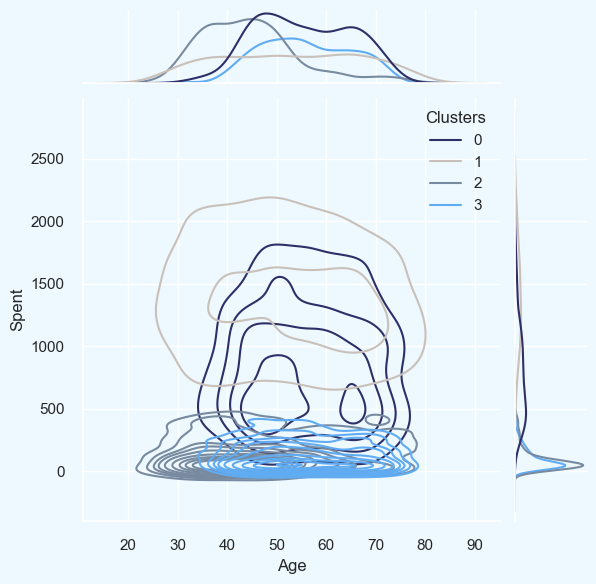

<Figure size 800x550 with 0 Axes>

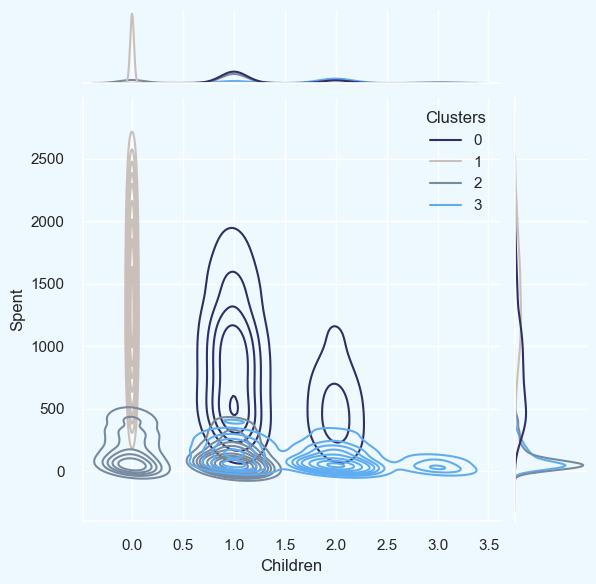

<Figure size 800x550 with 0 Axes>

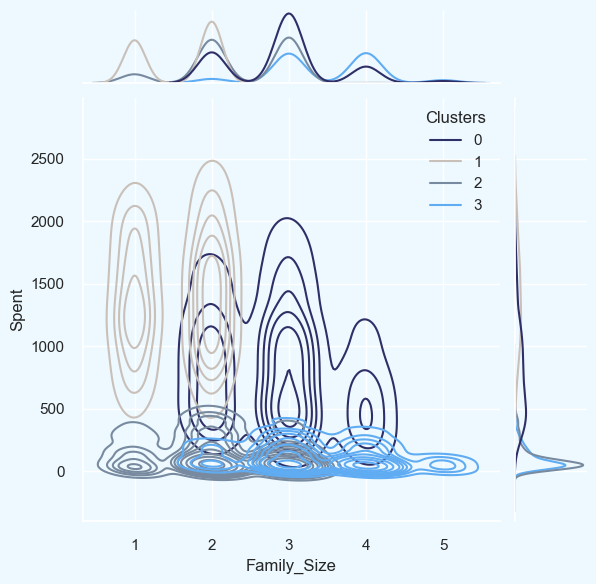

<Figure size 800x550 with 0 Axes>

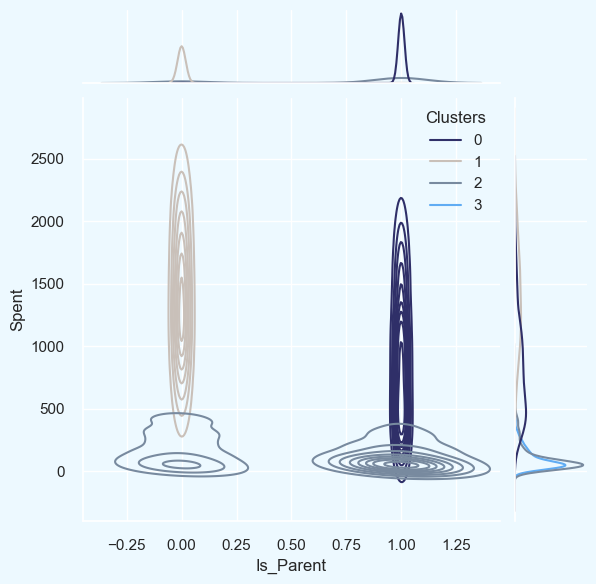

<Figure size 800x550 with 0 Axes>

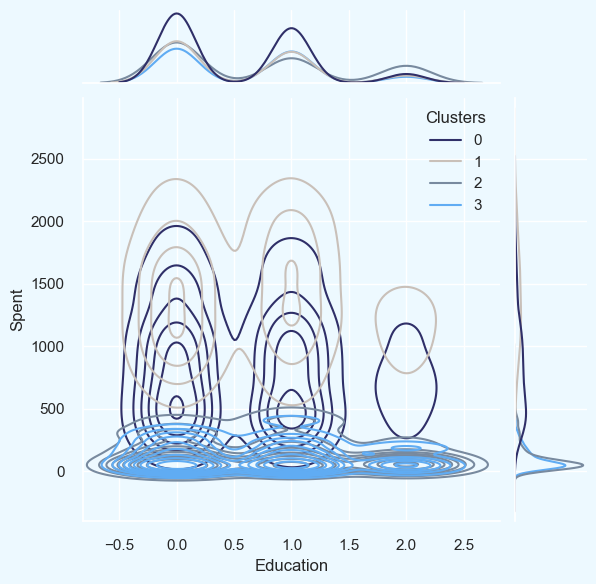

<Figure size 800x550 with 0 Axes>

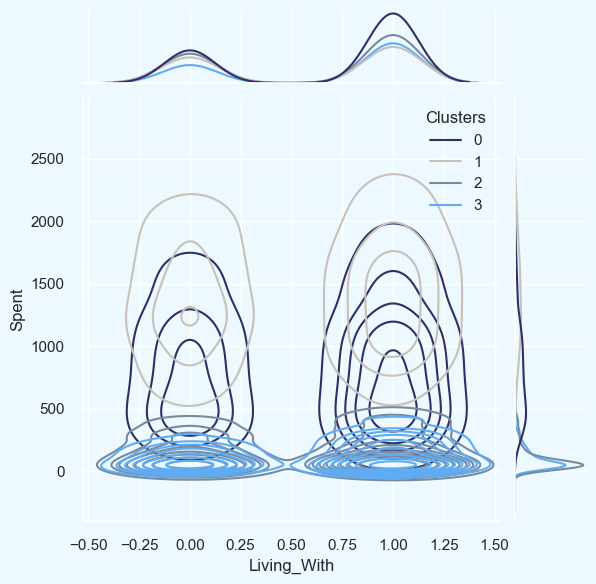

In [28]:
personal_info = ["Kidhome", "Teenhome", "Customer_For", "Age", "Children", "Family_Size", "Is_Parent", "Education",
            "Living_With"]

for i in personal_info:
    plt.figure()
    sns.jointplot(x=data[i], y=data["Spent"], hue=data["Clusters"], kind="kde", palette=pal)
    plt.show()


**Observations:**

**About Cluster Number: 0**
As shown in the chart, it can be concluded that the group being discussed is a group of parents who are relatively old and have a family with a maximum of four members and at least two members. Most of the parents in this group have a teenager at home, and single parents are a subset of this group. However, please note that this is only a conclusion based on the information provided, and it may not be accurate in all cases. It is important to verify and confirm any information before making conclusions or decisions based on it.

**About Cluster Number: 1**
According to the data in the charts, it can be concluded that the group being discussed is a group of non-parents who have a maximum of two members in their families. The majority of this group consists of couples, rather than single people. The members of this group span a wide range of ages and are part of a high-income group. However, please note that this is only a conclusion based on the information provided, and it may not be accurate in all cases. It is important to verify and confirm any information before making conclusions or decisions based on it.

**About Cluster Number: 2**
The charts indicate, it can be concluded that the group being discussed is a group of parents who are relatively younger and have families with a maximum of three members. Most of these parents have one child, who is typically not a teenager. However, please note that this is only a conclusion based on the information provided, and it may not be accurate in all cases. It is important to verify and confirm any information before making conclusions or decisions based on it.

**About Cluster Number: 3**
The data in the charts suggests, it can be concluded that the group being discussed is a group of parents who are relatively older and have a family with a maximum of five members and at least two members. Most of these parents have a teenager at home, and they are part of a lower-income group. However, please note that this is only a conclusion based on the information provided, and it may not be accurate in all cases. It is important to verify and confirm any information before making conclusions or decisions based on it.
